# Project Analyzing the Reasons for End of Employment

In this project, two surveys will be analyzed, both describing the ending of employment at two different institutes.
The `DETE` dataset was collected by the [Department of Education, Training and Employment](https://en.wikipedia.org/wiki/Department_of_Education_and_Training_(Queensland)) and the `TAFE` dataset is based on former employees of the [Technical and Further Education](https://en.wikipedia.org/wiki/Technical_and_further_education), both of Queensland, Australia.
The goal of this project will be to find out if there is a certain kind of dissatisfation that can be blamed on the end of employment for:
* short term employees
* long term employees

Importing and reading in data:

## Setup

In [3]:
import numpy as np
import pandas as pd

dete_survey = pd.read_csv('dete_survey.csv')
tafe_survey = pd.read_csv('tafe_survey.csv')


## Overview

In [4]:
# Overview over the dete_survey data
print(dete_survey.info())
print(dete_survey.head(1))
print(dete_survey.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 56 columns):
ID                                     822 non-null int64
SeparationType                         822 non-null object
Cease Date                             822 non-null object
DETE Start Date                        822 non-null object
Role Start Date                        822 non-null object
Position                               817 non-null object
Classification                         455 non-null object
Region                                 822 non-null object
Business Unit                          126 non-null object
Employment Status                      817 non-null object
Career move to public sector           822 non-null bool
Career move to private sector          822 non-null bool
Interpersonal conflicts                822 non-null bool
Job dissatisfaction                    822 non-null bool
Dissatisfaction with the department    822 non-null bool
Physical work environ

# Dete Survey

* 56 rows
* A lot of columns are y/n answers
* The last few columns are about origin of the employee and disability. These columns are predominantly made up of NaN values.
* In total over half the columns have NaN values
* The NaN values are called 'not stated' instead of nan in the dataset


In [5]:
# Tafe Survey Data overview

print(tafe_survey.info())
print(tafe_survey.head())
print(tafe_survey.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 72 columns):
Record ID                                                                                                                                                        702 non-null float64
Institute                                                                                                                                                        702 non-null object
WorkArea                                                                                                                                                         702 non-null object
CESSATION YEAR                                                                                                                                                   695 non-null float64
Reason for ceasing employment                                                                                                                                    701 non-

      Record ID                              Institute  \
0  6.341330e+17  Southern Queensland Institute of TAFE   
1  6.341337e+17            Mount Isa Institute of TAFE   
2  6.341388e+17            Mount Isa Institute of TAFE   
3  6.341399e+17            Mount Isa Institute of TAFE   
4  6.341466e+17  Southern Queensland Institute of TAFE   

                   WorkArea  CESSATION YEAR Reason for ceasing employment  \
0  Non-Delivery (corporate)          2010.0              Contract Expired   
1  Non-Delivery (corporate)          2010.0                    Retirement   
2       Delivery (teaching)          2010.0                    Retirement   
3  Non-Delivery (corporate)          2010.0                   Resignation   
4       Delivery (teaching)          2010.0                   Resignation   

  Contributing Factors. Career Move - Public Sector   \
0                                                NaN   
1                                                  -   
2                   

## tafe_survey data overview

* has 72 columns
* 702 rows
* 69 of the 72 columns have NaN values


## Observations about both datasets:

* They contain a lot of columns that are not needed for this analysis
* They contain a lot of columns with the same information, but with different names

## Data Cleaning

In [6]:
# read the dete survey again, but using Not Stated as the NaN parameter

dete_survey = pd.read_csv('dete_survey.csv', na_values = 'Not Stated')

# drop some columns not useful in this analysis

dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49], axis = 1)

tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66], axis = 1)


In [9]:
# standardizing column names
## dete survey standardization
dete_survey_updated.columns = dete_survey_updated.columns.str.lower().str.strip().str.replace(r'\s+', '_')

# tafe standardization
tafe_dic = {'Record ID': 'id', 'CESSATION YEAR' : 'cease_date', 'Reason for ceasing employment' : 'separationtype',
           'Gender. What is your Gender?' : 'gender', 'CurrentAge. Current Age' : 'age', 'Employment Type. Employment Type' : 'employment_status',
            'Classification. Classification' : 'position', 'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service',
           'LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'}
tafe_survey_updated.rename(columns = tafe_dic, inplace = True)
print(dete_survey_updated.columns)



Index(['id', 'separationtype', 'cease_date', 'dete_start_date',
       'role_start_date', 'position', 'classification', 'region',
       'business_unit', 'employment_status', 'career_move_to_public_sector',
       'career_move_to_private_sector', 'interpersonal_conflicts',
       'job_dissatisfaction', 'dissatisfaction_with_the_department',
       'physical_work_environment', 'lack_of_recognition',
       'lack_of_job_security', 'work_location', 'employment_conditions',
       'maternity/family', 'relocation', 'study/travel', 'ill_health',
       'traumatic_incident', 'work_life_balance', 'workload',
       'none_of_the_above', 'gender', 'age', 'aboriginal', 'torres_strait',
       'south_sea', 'disability', 'nesb'],
      dtype='object')


### Changes to column names

For concatenation --> standardized column names

Changes made:

* `dete_survey`: no capitalization, no unneccessary whitespaces, turn whitespaces between words into underscores --> `dete_survey_updated`

* `tafe_survey`: renaming columns important for the data analysis to match the columns of the `dete_survey_updated`

In [10]:
tafe_survey_updated['separationtype'].value_counts()

Resignation                 340
Contract Expired            127
Retrenchment/ Redundancy    104
Retirement                   82
Transfer                     25
Termination                  23
Name: separationtype, dtype: int64

### unifying and isolating the resignation rows

`TAFE`: saved all rows with `'separation'` in the `'separationtype'` column to the `tafe_resignations` dataframe

`DETE`: had 3 different entries for `'Separation'`:
    1. Set all of them as 'Separation'
    2. Saved all 'separation' rows to the `dete_resignations` dataframe

In [11]:
# Saving all resignation rows to separate dataframe: tafe
tafe_resignations = tafe_survey_updated.loc[tafe_survey_updated['separationtype'] =='Resignation'].copy()

#Setting all 
dete_survey_updated.loc[dete_survey_updated['separationtype'].str.contains(r'Resignation'), 'separationtype'] = 'Resignation' 

# Saving all resignation rows to separate dataframe: dete
dete_resignations = dete_survey_updated.loc[dete_survey_updated['separationtype'] =='Resignation'].copy()

# extracting just the years and saving them to the column in dete_resignation
dete_resignations['cease_date'] = dete_resignations['cease_date'].str.extract(pat = '(\d{4})', expand = False).astype(float)

# Turnin the dates in dete_start_date from strings into floats
print(dete_resignations['dete_start_date'].astype(float))

3      2005.0
5      1994.0
8      2009.0
9      1997.0
11     2009.0
        ...  
808    2010.0
815    2012.0
816    2012.0
819    2009.0
821       NaN
Name: dete_start_date, Length: 311, dtype: float64


In [11]:
print('TAFE resignation Years:\n')
print(tafe_resignations['cease_date'].value_counts(dropna = False))

print('\n\nDETE resignation Years:\n')
print(dete_resignations['cease_date'].value_counts(dropna = False))

print('\n\nDETE start Years:\n')
print(dete_resignations['dete_start_date'].value_counts(dropna = False).
      sort_index(ascending = False))


TAFE resignation Years:

 2011.0    116
 2012.0     94
 2010.0     68
 2013.0     55
NaN          5
 2009.0      2
Name: cease_date, dtype: int64


DETE resignation Years:

 2013.0    146
 2012.0    129
 2014.0     22
NaN         11
 2010.0      2
 2006.0      1
Name: cease_date, dtype: int64


DETE start Years:

 2013.0    10
 2012.0    21
 2011.0    24
 2010.0    17
 2009.0    13
 2008.0    22
 2007.0    21
 2006.0    13
 2005.0    15
 2004.0    14
 2003.0     6
 2002.0     6
 2001.0     3
 2000.0     9
 1999.0     8
 1998.0     6
 1997.0     5
 1996.0     6
 1995.0     4
 1994.0     6
 1993.0     5
 1992.0     6
 1991.0     4
 1990.0     5
 1989.0     4
 1988.0     4
 1987.0     1
 1986.0     3
 1985.0     3
 1984.0     1
 1983.0     2
 1982.0     1
 1980.0     5
 1977.0     1
 1976.0     2
 1975.0     1
 1974.0     2
 1973.0     1
 1972.0     1
 1971.0     1
 1963.0     1
NaN        28
Name: dete_start_date, dtype: int64


## Interpretation:

* TAFE resignation years:
    * data from 2009-2013
    * has 5 NaN values
    
* DETE resignation years:
    * has dates 2006, 2010 and 2012-2014
    * 11 NaN values
    
* DETE start years:
    * 28 NaN values
    * Dates from 1963 to 2013

In [12]:
print(dete_resignations.columns)
print(tafe_resignations.columns)

Index(['id', 'separationtype', 'cease_date', 'dete_start_date',
       'role_start_date', 'position', 'classification', 'region',
       'business_unit', 'employment_status', 'career_move_to_public_sector',
       'career_move_to_private_sector', 'interpersonal_conflicts',
       'job_dissatisfaction', 'dissatisfaction_with_the_department',
       'physical_work_environment', 'lack_of_recognition',
       'lack_of_job_security', 'work_location', 'employment_conditions',
       'maternity/family', 'relocation', 'study/travel', 'ill_health',
       'traumatic_incident', 'work_life_balance', 'workload',
       'none_of_the_above', 'gender', 'age', 'aboriginal', 'torres_strait',
       'south_sea', 'disability', 'nesb'],
      dtype='object')
Index(['id', 'Institute', 'WorkArea', 'cease_date', 'separationtype',
       'Contributing Factors. Career Move - Public Sector ',
       'Contributing Factors. Career Move - Private Sector ',
       'Contributing Factors. Career Move - Self-employmen

This means we can use the available data to calculate the institute service. For TAFE we have the entry and exit years. For DETE we have the institute_status already calculated

Now adding an 'institute_service' column to the dete_resignations dataframe

In [13]:
dete_resignations['institute_service'] = dete_resignations['cease_date'] - dete_resignations['dete_start_date']

Since the reasons for resignation were divided into many different columns with using different syntax, in the next cell, a new column (dissatisfied) is created to combine all the dissatisfaction reasons into one boolean column in the next cell.

In [148]:
def update_vals(value):
    
    if pd.isnull(value):
        return np.nan
    
    elif value == '-':
        return False
    
    else:
        return True
    
tafe_resignations['dissatisfied'] = (tafe_resignations[['Contributing Factors. Dissatisfaction',
                  'Contributing Factors. Job Dissatisfaction']]
                                     .applymap(update_vals).any(axis = 1, skipna =False)

                                                                                         
dis_list = dete_resignations.columns[[13,14,15,16,17,18,19,25,26]]
dete_resignations['dissatisfied'] = dete_resignations[dis_list].any(axis = 1, skipna = False)
#print(dete_resignations.columns[25:27])#[13:20])
dete_resignations_up = dete_resignations.copy()
tafe_resignations_up = tafe_resignations.copy()
# print((tafe_resignations[tafe_resignations.columns[5]] != '-').value_counts())

SyntaxError: invalid syntax (<ipython-input-148-752659b6c1c4>, line 17)

In [149]:
# New column to distinguish between datasets
dete_resignations_up['institute'] = 'DETE'
tafe_resignations_up['institute'] = 'TAFE'
print(dete_resignations_up.shape)
print(tafe_resignations_up.shape)

(311, 38)
(340, 25)


Combining the two datasets and dropping all columns with fewer than 500 non-na values to quickly eliminate unneeded data

In [150]:
combined = pd.concat([dete_resignations_up, tafe_resignations_up], ignore_index = True)
# print(combined.shape)
combined_updated = combined.dropna(axis = 1, thresh = 500).copy()
# print(combined_updated.shape)
# print(combined_updated.columns)

The 'institute_service' column is a combination of calculated years in the one dataframe and strings such as '3-4 years' in the other. The next cell

In [151]:
# combined_updated.loc[:,'institute_service_up'] 
combined_updated['institute_service_up'] = (combined_updated.loc[:,'institute_service']
     .astype('str').str.extract((r'(\d+)'),expand = False).astype('float'))
#combined_updated['institute_service_up'] = combined_updated['institute_service_up'].astype('float')
# print(combined_updated['institute_service_up'].value_counts(dropna = False))
# a[combined_updated['institute_service'].isnull()] = np.nan
# a.astype('float')

Turn the float into different employment length categories

Next: a function to put employees into drawers of experience

In [152]:
def drawers(years):
    if pd.isnull(years):
        return 'unknown'
    elif years < 3:
        return 'New'
    elif years <= 6:
        return 'Experienced'
    elif years <= 10:
        return 'Established'
    else:
        return 'Veteran'

Using the function on the 'institute_service_up' column to create new column 'service_cat' for the different service-lenght categories

In [153]:
combined_updated['service_cat'] = combined_updated['institute_service_up'].map(drawers)

In [154]:
combined_updated['dissatisfied'].value_counts(dropna = False)

False    403
True     240
NaN        8
Name: dissatisfied, dtype: int64

Filling the NaNs with the most common element: False

In [158]:
combined_updated['dissatisfied'] = (combined_updated['dissatisfied'].fillna(False))

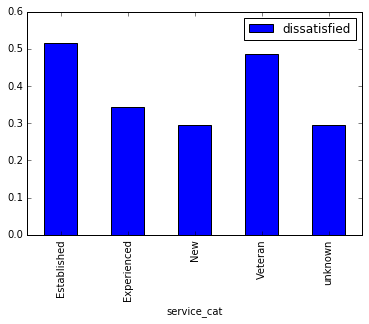

In [162]:
%matplotlib inline
combined_updated.pivot_table(index = 'service_cat', values = 'dissatisfied').plot(kind = 'bar')

Most people that quit due to dissatisfaction were employees that worked for more than 3 years